In [29]:
import gc
import os

import tensorflow
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont

In [3]:
model = tensorflow.keras.models.load_model('../model/my_model')

In [4]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [5]:
IMG_SIZE=64
N_CHANNELS=1

In [6]:
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [7]:
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(1,2):
    df_test_img = pd.read_parquet('../input/bengaliai-cv19/test_image_data_{}.parquet'.format(i)) 
    df_test_img.set_index('image_id', inplace=True)
    df_test_img = df_test_img.iloc[:20, :]

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[i], axis=1)
    
    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
# df_sample.to_csv('submission.csv',index=False)
df_sample.head()

,row_id,target
0,Test_3_consonant_diacritic,0
1,Test_3_grapheme_root,115
2,Test_3_vowel_diacritic,0
3,Test_4_consonant_diacritic,0
4,Test_4_grapheme_root,55


In [8]:
df_sample.head(10)

,row_id,target
0,Test_3_consonant_diacritic,0
1,Test_3_grapheme_root,115
2,Test_3_vowel_diacritic,0
3,Test_4_consonant_diacritic,0
4,Test_4_grapheme_root,55
5,Test_4_vowel_diacritic,4
6,Test_5_consonant_diacritic,0
7,Test_5_grapheme_root,115
8,Test_5_vowel_diacritic,2


In [92]:
for i in range(int(df_sample.shape[0]/3)):
    df_sample_copy = df_sample.copy()
    df_sample_unit = df_sample_copy.iloc[i*3: (i*3+3), :]
    df_sample_unit['row_id'] = df_sample_unit['row_id'].apply(lambda x: x.split('_', 2)[2])
    df_sample_unit = df_sample_unit.merge(class_map_df, how='inner', left_on=['row_id', 'target'], right_on=['component_type', 'label'])
    df_sample_unit = df_sample_unit.drop(columns=['row_id', 'label'])
    grapheme = ''
    for i in df_sample_unit['component']:
        if i != '0':
            grapheme+=i
    print(grapheme)

ম
ঠু
মি


C:\Users\jawad\miniconda3\envs\bengali-grapheme\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [96]:
df_test_img = pd.read_parquet('../input/bengaliai-cv19/test_image_data_{}.parquet'.format(1)) 
df_test_img.set_index('image_id', inplace=True)
df_test_img = df_test_img.iloc[:20, :]

In [97]:
df_test_img

,0,1,2,3,4,5,6,7,8,9,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
image_id,,,,,,,,,,,,,,,,,,,,,
Test_3,199,227,236,241,238,242,245,243,243,245,...,222,222,226,224,222,227,220,208,194,136
Test_4,243,246,251,252,251,249,250,250,251,252,...,251,252,252,252,252,253,253,253,253,253
Test_5,251,250,250,251,252,254,252,251,251,252,...,253,253,252,252,252,253,252,249,248,249


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1500.29it/s]


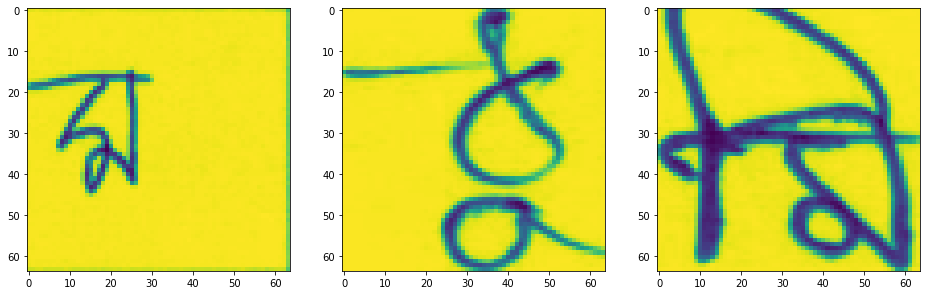

In [98]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
count=0
# for row in ax:
for col in ax:
    col.imshow(resize(df_test_img).iloc[[count]].values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
    count += 1
plt.show()

In [101]:
'র্'+ "অ" + "ে"

'র্অে'

In [69]:
for i in range(1):
    df_test_img = pd.read_parquet('../input/bengaliai-cv19/train_image_data_{}.parquet'.format(i))
    df_test_img.set_index('image_id', inplace=True)
    for j in tqdm(range(100)):
        image = df_test_img.loc[df_test_img.index[j]].values.reshape(137,236)
        cv2.imwrite(f"../input/upload-images/sample-{i}-{j}.png", image)
#     df_test_img.set_index('image_id', inplace=True)
#     df_test_img = df_test_img.iloc[:1000, :]
#     np.array(resize(df_test_img, need_progress_bar=False))
#     for j in range(3):
#         sample = np.array(resize(df_test_img, need_progress_bar=False)[1].iloc[j, :])
#         cv2.imwrite(f"../input/sample-images/sample-{i}-{j}.png", sample)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 242.12it/s]


In [9]:
class_map_df = pd.read_csv('../input/bengaliai-cv19/class_map.csv')

In [10]:
class_map_df

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই
...,...,...,...
181,consonant_diacritic,2,র্
182,consonant_diacritic,3,র্য
183,consonant_diacritic,4,্য
184,consonant_diacritic,5,্র


In [11]:
class_map_df[class_map_df['component_type'] == "consonant_diacritic"]

,component_type,label,component
179,consonant_diacritic,0,0
180,consonant_diacritic,1,ঁ
181,consonant_diacritic,2,র্
182,consonant_diacritic,3,র্য
183,consonant_diacritic,4,্য
184,consonant_diacritic,5,্র
185,consonant_diacritic,6,্র্য


array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

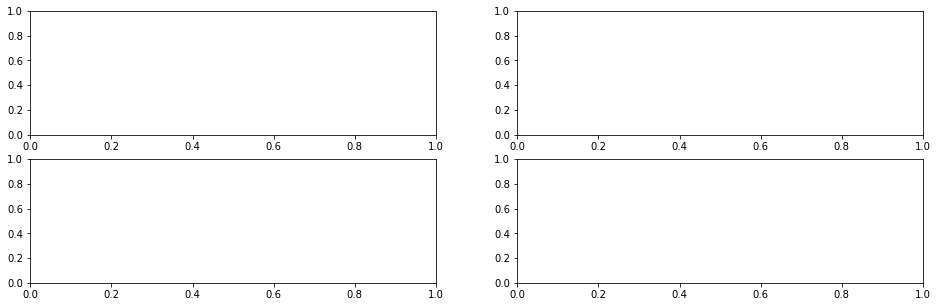

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 5))
ax

In [26]:
X_test = resize(df_test_img, need_progress_bar=False)/255
X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

In [27]:
X_test

array([[[[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.45882353],
         [0.10588235],
         [0.21568627]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.12156863],
         [0.09803922],
         [0.15294118]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.1254902 ],
         [0.13333333],
         [0.16470588]],

        ...,

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.86666667],
         [0.98039216],
         [0.98823529]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.97647059],
         [0.99607843],
         [0.99215686]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.99607843],
         [1.        ],
         [1.        ]]],


       [[[1.        ],
         [1.        ],
         [1.  

In [21]:
# def resize(images_dir, size=64, need_progress_bar=True):
def resize(images_dir, size=64):
    resized = pd.DataFrame()
    resize_size=64
    for i, image_path in enumerate(os.listdir(images_dir)):
        image = cv2.imread(os.path.join(images_dir, image_path), 0)
        image = image.reshape(137,236)
        _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

        idx = 0 
        ls_xmin = []
        ls_ymin = []
        ls_xmax = []
        ls_ymax = []
        for cnt in contours:
            idx += 1
            x,y,w,h = cv2.boundingRect(cnt)
            ls_xmin.append(x)
            ls_ymin.append(y)
            ls_xmax.append(x + w)
            ls_ymax.append(y + h)
        xmin = min(ls_xmin)
        ymin = min(ls_ymin)
        xmax = max(ls_xmax)
        ymax = max(ls_ymax)

        roi = image[ymin:ymax,xmin:xmax]
        resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
        resized[f"image_{i}"] = resized_roi.reshape(-1)
    return resized.T

In [22]:
resize('../input/sample-images/')

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
image_0,251,247,247,246,236,220,195,141,203,228,...,252,253,254,254,254,254,254,255,255,255
image_1,254,254,254,254,254,254,254,254,254,252,...,221,246,245,247,251,254,254,254,254,254
image_2,249,250,248,249,249,250,250,250,250,251,...,254,254,255,255,255,255,255,255,255,255
image_3,245,246,248,246,244,246,247,245,243,244,...,235,233,235,238,230,234,237,238,235,194
image_4,254,254,253,254,254,254,254,254,254,253,...,253,253,253,252,252,252,253,253,253,253
image_5,251,226,123,62,62,110,221,250,253,253,...,254,250,242,214,146,132,173,230,250,251
image_6,255,255,255,254,253,253,254,254,254,254,...,255,255,255,253,249,229,241,254,255,255
image_7,255,255,255,255,255,255,255,255,255,255,...,252,255,255,255,255,255,255,255,255,255
image_8,253,251,250,252,253,253,253,253,252,250,...,251,251,248,248,249,250,249,247,248,252
image_9,250,251,248,250,251,250,252,250,250,249,...,250,250,252,252,251,250,253,253,253,253


In [23]:
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder

df_test_img = resize('../input/sample-images/')/255
X_test = df_test_img.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

preds = model.predict(X_test)

for i, p in enumerate(preds_dict):
    preds_dict[p] = np.argmax(preds[i], axis=1)

for k,id in enumerate(df_test_img.index.values):  
    for i,comp in enumerate(components):
        id_sample=id+'_'+comp
        row_id.append(id_sample)
        target.append(preds_dict[comp][k])

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
# df_sample.to_csv('submission.csv',index=False)
df_sample.head()

,row_id,target
0,image_0_consonant_diacritic,0
1,image_0_grapheme_root,3
2,image_0_vowel_diacritic,0
3,image_1_consonant_diacritic,0
4,image_1_grapheme_root,93


In [24]:
df_sample

,row_id,target
0,image_0_consonant_diacritic,0
1,image_0_grapheme_root,3
2,image_0_vowel_diacritic,0
3,image_1_consonant_diacritic,0
4,image_1_grapheme_root,93
5,image_1_vowel_diacritic,2
6,image_2_consonant_diacritic,0
7,image_2_grapheme_root,19
8,image_2_vowel_diacritic,0
9,image_3_consonant_diacritic,0


In [25]:
df_test_img

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
image_0,0.984314,0.968627,0.968627,0.964706,0.925490,0.862745,0.764706,0.552941,0.796078,0.894118,...,0.988235,0.992157,0.996078,0.996078,0.996078,0.996078,0.996078,1.000000,1.000000,1.000000
image_1,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.988235,...,0.866667,0.964706,0.960784,0.968627,0.984314,0.996078,0.996078,0.996078,0.996078,0.996078
image_2,0.976471,0.980392,0.972549,0.976471,0.976471,0.980392,0.980392,0.980392,0.980392,0.984314,...,0.996078,0.996078,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
image_3,0.960784,0.964706,0.972549,0.964706,0.956863,0.964706,0.968627,0.960784,0.952941,0.956863,...,0.921569,0.913725,0.921569,0.933333,0.901961,0.917647,0.929412,0.933333,0.921569,0.760784
image_4,0.996078,0.996078,0.992157,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.992157,...,0.992157,0.992157,0.992157,0.988235,0.988235,0.988235,0.992157,0.992157,0.992157,0.992157
image_5,0.984314,0.886275,0.482353,0.243137,0.243137,0.431373,0.866667,0.980392,0.992157,0.992157,...,0.996078,0.980392,0.949020,0.839216,0.572549,0.517647,0.678431,0.901961,0.980392,0.984314
image_6,1.000000,1.000000,1.000000,0.996078,0.992157,0.992157,0.996078,0.996078,0.996078,0.996078,...,1.000000,1.000000,1.000000,0.992157,0.976471,0.898039,0.945098,0.996078,1.000000,1.000000
image_7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.988235,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
image_8,0.992157,0.984314,0.980392,0.988235,0.992157,0.992157,0.992157,0.992157,0.988235,0.980392,...,0.984314,0.984314,0.972549,0.972549,0.976471,0.980392,0.976471,0.968627,0.972549,0.988235
image_9,0.980392,0.984314,0.972549,0.980392,0.984314,0.980392,0.988235,0.980392,0.980392,0.976471,...,0.980392,0.980392,0.988235,0.988235,0.984314,0.980392,0.992157,0.992157,0.992157,0.992157


C:\Users\jawad\miniconda3\envs\bengali-grapheme\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\jawad\miniconda3\envs\bengali-grapheme\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 2453 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jawad\miniconda3\envs\bengali-grapheme\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 2509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jawad\miniconda3\envs\bengali-grapheme\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 2488 missing from current font.
  font.set_t

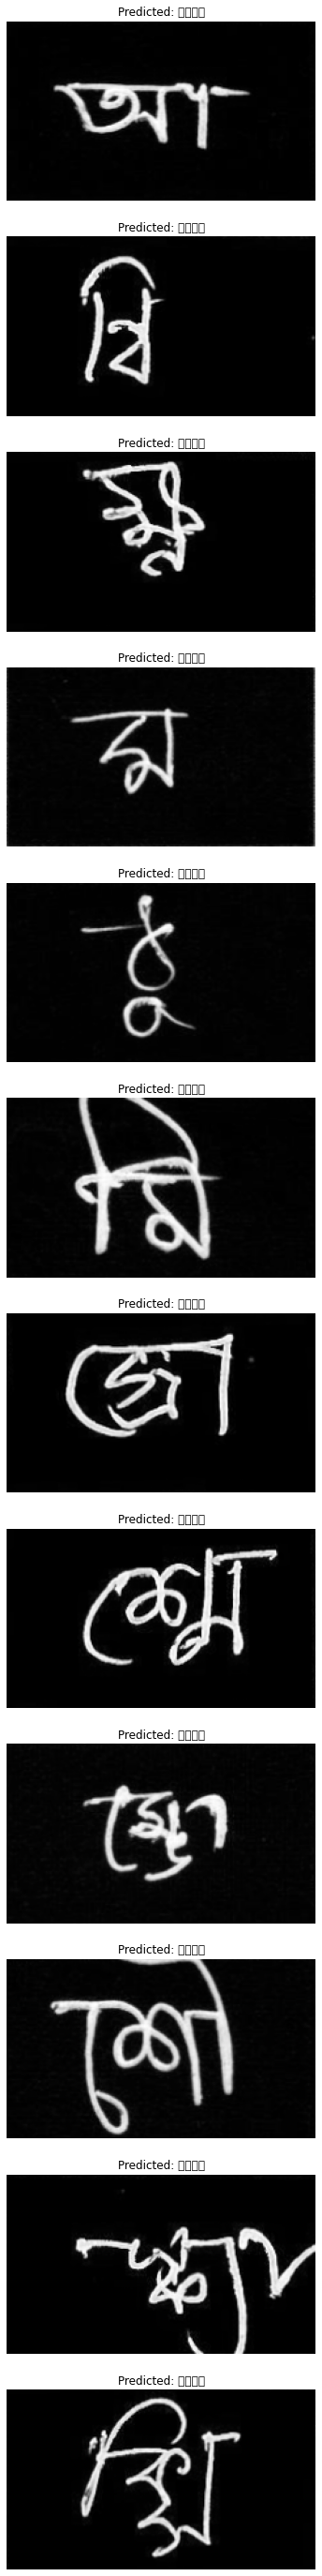

In [66]:
images_dir = '../input/sample-images/'

test_images = df_test_img.values.reshape(-1, IMG_SIZE, IMG_SIZE)
f, ax = plt.subplots(test_images.shape[0], 1, figsize=(20, 50))
ax = ax.flatten()
    
for i in range(int(df_sample.shape[0]/3)):
    df_sample_copy = df_sample.copy()
    df_sample_unit = df_sample_copy.iloc[i*3: (i*3+3), :]
    df_sample_unit['row_id'] = df_sample_unit['row_id'].apply(lambda x: x.split('_', 2)[2])
    df_sample_unit = df_sample_unit.merge(class_map_df, how='inner', left_on=['row_id', 'target'], right_on=['component_type', 'label'])
    df_sample_unit = df_sample_unit.drop(columns=['row_id', 'label'])
    grapheme_list = []
    for j in df_sample_unit['component']:
        grapheme_list.append(j)
    if grapheme_list[0] != "র্":
        temp = grapheme_list[0]
        grapheme_list[0] = grapheme_list[1]
        grapheme_list[1] = temp
    
    grapheme_list = list(filter(('0').__ne__, grapheme_list))
    grapheme = ''.join(grapheme_list)

for i, image_path in enumerate(os.listdir(images_dir)):
    image = cv2.imread(os.path.join(images_dir, image_path), 0)
    ax[i].imshow(image, cmap='Greys')
    ax[i].axis('off')
#     ax[i].title.set_text(f'Predicted: {grapheme}')

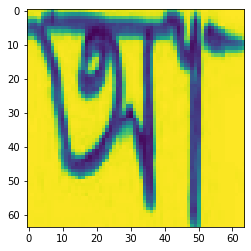

In [41]:
plt.imshow(test_images[0])

In [ ]:
image_from_char(char)

In [15]:
''.join(["ম","ে"])

'মে'

In [13]:
"ম"+"্য"+"ে"

'ম্যে'